**1. Data Cleaning and Preprocessing**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer

# Load dataset
df = pd.read_csv("heart_disease.csv")

# Drop duplicates and missing values
df = df.drop_duplicates().dropna()

# Normalize numeric columns using Min-Max scaling
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Discretize normalized data into 3 bins
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
df[numeric_cols] = kbins.fit_transform(df[numeric_cols])

# Convert all numeric columns to int (required by pgmpy)
df[numeric_cols] = df[numeric_cols].astype(int)

# Preview cleaned data
print("✅ Cleaned and Discretized Data Sample:")
print(df.head())
df.to_csv("cleaned_heart_disease.csv", index=False)

# Download the file to your local machine
from google.colab import files
files.download("cleaned_heart_disease.csv")

✅ Cleaned and Discretized Data Sample:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0    2    2   2         1     0    2        0        1      0        1      0   
1    0    2   2         1     0    0        1        2      0        1      0   
2    0    0   1         1     0    0        0        2      0        0      2   
3    1    2   1         0     0    0        1        2      0        0      2   
4    1    0   0         0     1    0        1        2      2        0      2   

   ca  thal  target  
0   0     1       2  
1   0     2       2  
2   0     2       2  
3   0     2       2  
4   0     2       2  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**2. Define and Train the Bayesian Network**

In [ ]:

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

# Define the Bayesian structure: age → fbs → target → chol, thalach
model = DiscreteBayesianNetwork([
    ('age', 'fbs'),
    ('fbs', 'target'),
    ('target', 'chol'),
    ('target', 'thalach')
])

# Train the model using Maximum Likelihood Estimation
model.fit(df, estimator=MaximumLikelihoodEstimator)

print("\n✅ Model trained using MLE.")



✅ Model trained using MLE.


**3. Set Up Inference and Helper Function**

In [ ]:

from pgmpy.inference import VariableElimination

# Create inference engine
infer = VariableElimination(model)

# Helper: Validate evidence values
def safe_query(variable, evidence):
    for k, v in evidence.items():
        if v not in df[k].unique():
            raise ValueError(f"⚠️ Invalid value {v} for variable '{k}'. Must be one of {df[k].unique()}")
    return infer.query(variables=[variable], evidence=evidence)


**4. Query 1: P(target | fbs=2, age=1)**


🎯 P(target | fbs=2, age=1):
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4889 |
+-----------+---------------+
| target(2) |        0.5111 |
+-----------+---------------+


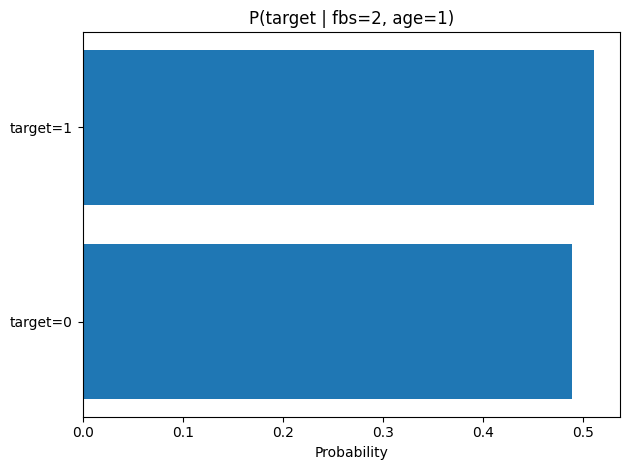

In [ ]:

try:
    result = safe_query('target', {'fbs': 2, 'age': 1})
    print("\n🎯 P(target | fbs=2, age=1):")
    print(result)
except ValueError as e:
    print(e)
plt.barh(range(len(result.values)), result.values)
plt.yticks(range(len(result.values)), [f"target={i}" for i in range(len(result.values))])
plt.xlabel("Probability")
plt.title("P(target | fbs=2, age=1)")
plt.tight_layout()
plt.savefig("inference_target_given_fbs_age.png")



** 5. Query 2: Most Likely thalach Value Given target=1**

In [ ]:

try:
    map_result = infer.map_query(variables=['thalach'], evidence={'target': 1})
    print("\n📈 Most likely thalach value given target=1:", map_result['thalach'])
except Exception as e:
    print(e)


0it [00:00, ?it/s]

0it [00:00, ?it/s]


📈 Most likely thalach value given target=1: 2


**Valid Values for Reference**

In [ ]:

print("\n🗂️ Valid variable values from dataset:")
for col in ['age', 'fbs', 'target', 'chol', 'thalach']:
    print(f"{col}: {sorted(df[col].unique())}")



🗂️ Valid variable values from dataset:
age: [np.int64(0), np.int64(1), np.int64(2)]
fbs: [np.int64(0), np.int64(2)]
target: [np.int64(0), np.int64(2)]
chol: [np.int64(0), np.int64(1), np.int64(2)]
thalach: [np.int64(0), np.int64(1), np.int64(2)]


**7. Visualize Network Structure**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


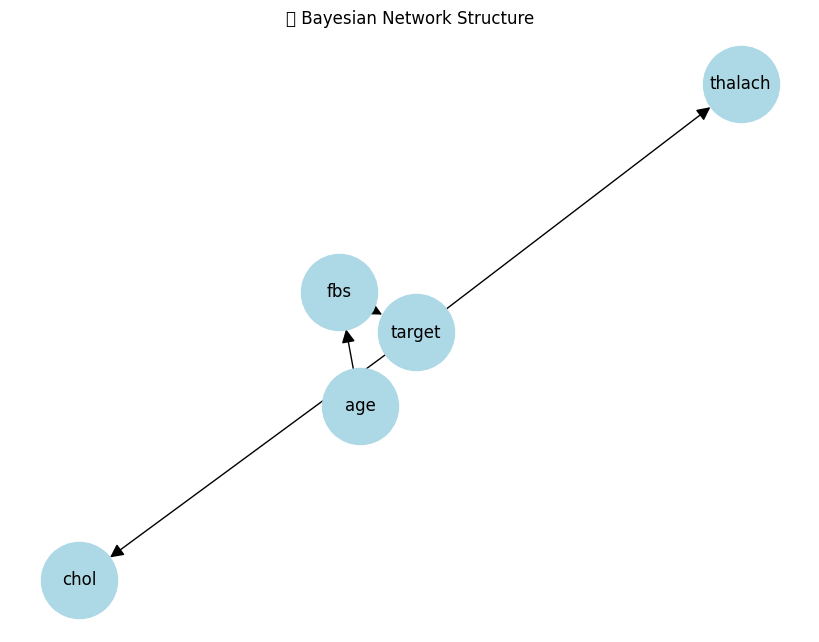

In [ ]:

import networkx as nx
import matplotlib.pyplot as plt

# Create and draw Bayesian graph
G = nx.DiGraph()
G.add_edges_from(model.edges())

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, arrowsize=20)
plt.title("📊 Bayesian Network Structure")
plt.show()


**8. Visualize CPDs (Conditional Probability Distributions)**


🔢 CPD for age:
 +--------+----------+
| age(0) | 0.182119 |
+--------+----------+
| age(1) | 0.556291 |
+--------+----------+
| age(2) | 0.261589 |
+--------+----------+


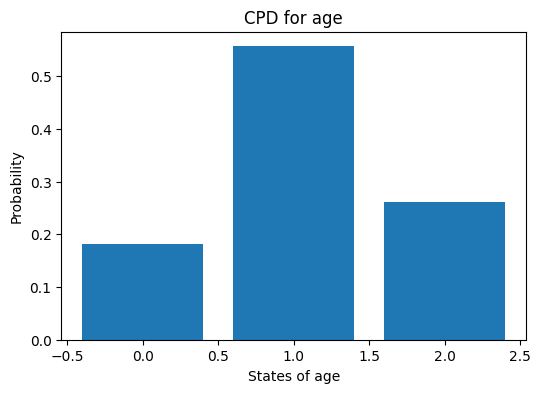


🔢 CPD for fbs:
 +--------+---------------------+---------------------+---------------------+
| age    | age(0)              | age(1)              | age(2)              |
+--------+---------------------+---------------------+---------------------+
| fbs(0) | 0.9454545454545454  | 0.8273809523809523  | 0.8354430379746836  |
+--------+---------------------+---------------------+---------------------+
| fbs(2) | 0.05454545454545454 | 0.17261904761904762 | 0.16455696202531644 |
+--------+---------------------+---------------------+---------------------+


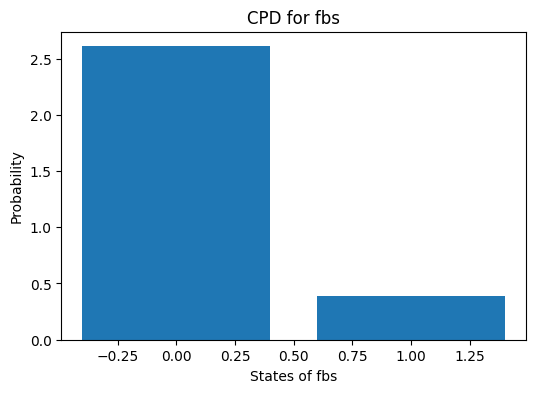


🔢 CPD for target:
 +-----------+---------------------+--------------------+
| fbs       | fbs(0)              | fbs(2)             |
+-----------+---------------------+--------------------+
| target(0) | 0.45136186770428016 | 0.4888888888888889 |
+-----------+---------------------+--------------------+
| target(2) | 0.5486381322957199  | 0.5111111111111111 |
+-----------+---------------------+--------------------+


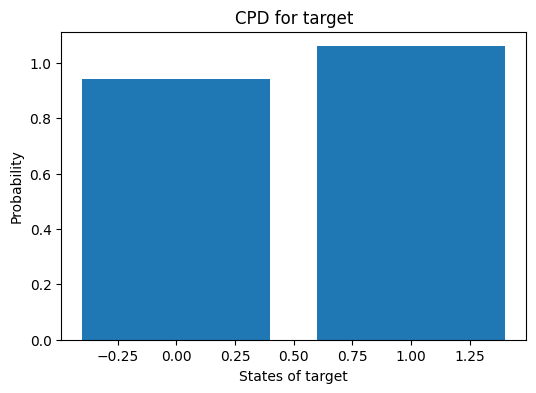


🔢 CPD for chol:
 +---------+---------------------+----------------------+
| target  | target(0)           | target(2)            |
+---------+---------------------+----------------------+
| chol(0) | 0.6594202898550725  | 0.7926829268292683   |
+---------+---------------------+----------------------+
| chol(1) | 0.34057971014492755 | 0.20121951219512196  |
+---------+---------------------+----------------------+
| chol(2) | 0.0                 | 0.006097560975609756 |
+---------+---------------------+----------------------+


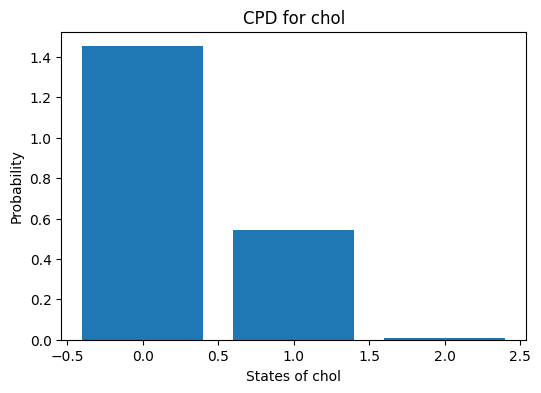


🔢 CPD for thalach:
 +------------+---------------------+----------------------+
| target     | target(0)           | target(2)            |
+------------+---------------------+----------------------+
| thalach(0) | 0.16666666666666666 | 0.024390243902439025 |
+------------+---------------------+----------------------+
| thalach(1) | 0.6159420289855072  | 0.4146341463414634   |
+------------+---------------------+----------------------+
| thalach(2) | 0.21739130434782608 | 0.5609756097560976   |
+------------+---------------------+----------------------+


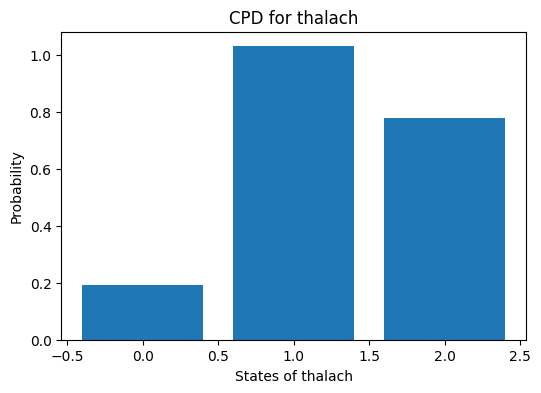

In [ ]:

for cpd in model.get_cpds():
    print(f"\n🔢 CPD for {cpd.variable}:\n", cpd)
    values = cpd.get_values()

    plt.figure(figsize=(6, 4))
    plt.title(f"CPD for {cpd.variable}")
    if values.ndim == 1:
        plt.bar(range(len(values)), values)
    else:
        marg_values = values.sum(axis=tuple(range(1, values.ndim)))
        plt.bar(range(len(marg_values)), marg_values)
    plt.xlabel(f"States of {cpd.variable}")
    plt.ylabel("Probability")
    plt.show()
